In [1]:
import os
import argparse
import time
import datetime
from tqdm import tqdm

from munch import Munch
from torch.backends import cudnn
import torch
import torch.nn.functional as F
import numpy as np

from core.my_loader import get_train_loader, get_test_loader, InputFetcher
from core.my_solver import Solver
from torchvision.transforms import Compose, Resize, Normalize, ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset, DataLoader

from easydict import EasyDict as edict
from core.my_solver import compute_d_loss, compute_g_loss, moving_average, adv_loss, r1_reg, Sampler, LoaderSampler, tensor2img
from core.my_metrics import get_Z_pushed_loader_stats, calculate_cost
from core.fid_score import calculate_frechet_distance

from IPython.display import clear_output
import matplotlib.pyplot as plt

os.environ['CUDA_VISIBLE_DEVICES'] = "6"

def str2bool(v):
    return v.lower() in ('true')


def subdirs(dname):
    return [d for d in os.listdir(dname)
            if os.path.isdir(os.path.join(dname, d))]

lambda_id = 500.0

args = edict({
    'img_size': 64,
    'num_domains': 2,
    'latent_dim': 16,
    'hidden_dim': 512,
    'style_dim': 64, 
    'lambda_reg': 1.0,
    'lambda_cyc': 1.0,
    'lambda_sty': 1.0,
    'lambda_ds': 1.0,
    'lambda_id': lambda_id,
    'ds_iter': 100000,
    'w_hpf': -1.0,
    'randcrop_prob': 0.5,
    'total_iters': 100000,
    'resume_iter': 0,
    'batch_size': 16,
    'val_batch_size': 32,
    'lr': 1e-4,
    'f_lr': 1e-6,
    'beta1': 0.0,
    'beta2': 0.99,
    'weight_decay': 1e-4,
    'num_outs_per_domain': 10,
    'mode': 'train', 
    'num_workers': 4,
    'seed': 777,
    'train_img_dir': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_train',
    'val_img_dir': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_test',
    'sample_dir': 'expr/samples',
    'checkpoint_dir': f'/cache/selikhanovych/OT_competitors/stargan-v2/celeba2anime_exps/checkpoints_lambda_{lambda_id}',
    'eval_dir': 'expr/eval',
    'result_dir': 'expr/results',
    'src_dir': 'assets/representative/celeba_hq/src',
    'ref_dir': 'assets/representative/celeba_hq/ref',
    'inp_dir': 'assets/representative/custom/female',
    'out_dir': 'assets/representative/celeba_hq/src/female',
    'wing_path': 'expr/checkpoints/wing.ckpt',
    'lm_path': 'expr/checkpoints/celeba_lm_mean.npz',
    'print_every': 10,
    'sample_every': 4000,
    'save_every': 4000,
    'eval_every': 4000,
    
    'target_dataset': 'aligned_anime_faces',
    'OUTPUT_PATH': f'/cache/selikhanovych/OT_competitors/stargan-v2/celeba2anime_exps/checkpoints_lambda_{lambda_id}',
    'domains': {
        'source': 'celeba_female',
        'target': 'aligned_anime_faces',
    },
    'train_a': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_train/celeba_female',
    'train_b': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_train/aligned_anime_faces', 
    'test_a': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_test/celeba_female',
    'test_b': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_test/aligned_anime_faces',
    
    'n_epochs': 1
})

os.system(f"mkdir -p {args.OUTPUT_PATH}")
os.system(f"mkdir -p {args.checkpoint_dir}")


eval_trg_domain = args.domains['target']
eval_src_domain = args.domains['source']

domains = os.listdir(args.val_img_dir)
domains.sort()

final_trg_index = -1
final_src_index = -1

for trg_idx, trg_domain in enumerate(domains):
    src_domains = [x for x in domains if x != trg_domain]
    for src_idx, src_domain in enumerate(src_domains):
        if src_domain == eval_src_domain and trg_domain == eval_trg_domain:
            final_trg_index = trg_idx
            final_src_index = src_idx
            
print(final_trg_index, final_src_index)

cudnn.benchmark = True
torch.manual_seed(args.seed)

solver = Solver(args)

assert len(subdirs(args.train_img_dir)) == args.num_domains
assert len(subdirs(args.val_img_dir)) == args.num_domains

loaders = Munch(src=get_train_loader(root=args.train_img_dir,
                                     which='source',
                                     img_size=args.img_size,
                                     batch_size=args.batch_size,
                                     num_workers=args.num_workers),
                ref=get_train_loader(root=args.train_img_dir,
                                     which='reference',
                                     img_size=args.img_size,
                                     batch_size=args.batch_size,
                                     num_workers=args.num_workers),
                val=get_test_loader(root=args.val_img_dir,
                                    img_size=args.img_size,
                                    batch_size=args.val_batch_size,
                                    shuffle=False,
                                    num_workers=args.num_workers))

device = 'cuda'

args = solver.args
nets = solver.nets
nets_ema = solver.nets_ema
optims = solver.optims

transform = Compose([Resize((args.img_size, args.img_size)),
                     ToTensor(),
                     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset_a = ImageFolder(args.train_a, transform)
train_dataset_b = ImageFolder(args.train_b, transform)
test_dataset_a = ImageFolder(args.test_a, transform)
test_dataset_b = ImageFolder(args.test_b, transform)

train_loader_a = DataLoader(dataset=train_dataset_a,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

train_loader_b = DataLoader(dataset=train_dataset_b,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

test_loader_a = DataLoader(dataset=test_dataset_a,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

test_loader_b = DataLoader(dataset=test_dataset_b,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

X_sampler = LoaderSampler(train_loader_a)
X_test_sampler = LoaderSampler(test_loader_a)
Y_sampler = LoaderSampler(train_loader_b)
Y_test_sampler = LoaderSampler(test_loader_b)


torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)
solver.X_fixed = X_sampler.sample(10)
solver.Y_fixed = Y_sampler.sample(10)

solver.X_test_fixed = X_test_sampler.sample(10)
solver.Y_test_fixed = Y_test_sampler.sample(10)

# fetch random validation images for debugging
fetcher = InputFetcher(loaders.src, loaders.ref, args.latent_dim, 'train')
fetcher_val = InputFetcher(loaders.val, None, args.latent_dim, 'val')
inputs_val = next(fetcher_val)

# resume training if necessary
if args.resume_iter > 0:
    solver._load_checkpoint(args.resume_iter)

# remember the initial value of ds weight
initial_lambda_ds = args.lambda_ds

eval_trg_domain = args.domains['target']
eval_src_domain = args.domains['source']

domains = os.listdir(args.val_img_dir)
domains.sort()
num_domains = len(domains)
for trg_idx, trg_domain in enumerate(domains):
    src_domains = [x for x in domains if x != trg_domain]
    for src_idx, src_domain in enumerate(src_domains):
        if src_domain == eval_src_domain and trg_domain == eval_trg_domain:
            print(f"trg_idx = {trg_idx}, trg_domain = {trg_domain}, src_domain = {src_domain}")
            break
    break
                    
print(f"trg_idx = {trg_idx}, lambda_id = {args.lambda_id}")

0 0
Number of parameters of generator: 32634883
Number of parameters of mapping_network: 2438272
Number of parameters of style_encoder: 20327808
Number of parameters of discriminator: 20263170
Initializing generator...
Initializing mapping_network...
Initializing style_encoder...
Initializing discriminator...
Preparing DataLoader to fetch source images during the training phase...
Preparing DataLoader to fetch reference images during the training phase...
Preparing DataLoader for the generation phase...
trg_idx = 0, trg_domain = aligned_anime_faces, src_domain = celeba_female
trg_idx = 0, lambda_id = 500.0


Computing l1 cost


591it [00:29, 20.23it/s]


l1 cost = 0.021287100123507634, best l1 cost = 0.021287100123507634, best iter = 96000
Computing l2 cost


591it [00:29, 19.97it/s]


l2 cost = 0.0010004025673841807, best l2 cost = 0.0010004025673841807, best iter = 96000
Computing FID
Calculating evaluation metrics...
Number of domains: 2
Compute FID for celeba_female2aligned_anime_faces, trg_idx = 0, trg_domain = aligned_anime_faces
Preparing DataLoader for the generation phase...


100%|██████████| 320/320 [00:39<00:00,  8.09it/s]


FID = 140.2756157657895, best FID = 139.12179450271827, best iter = 40000
FID = 140.2756157657895, best FID = 139.12179450271827, best iter = 40000
Plotting, iter = 96000
mode = train


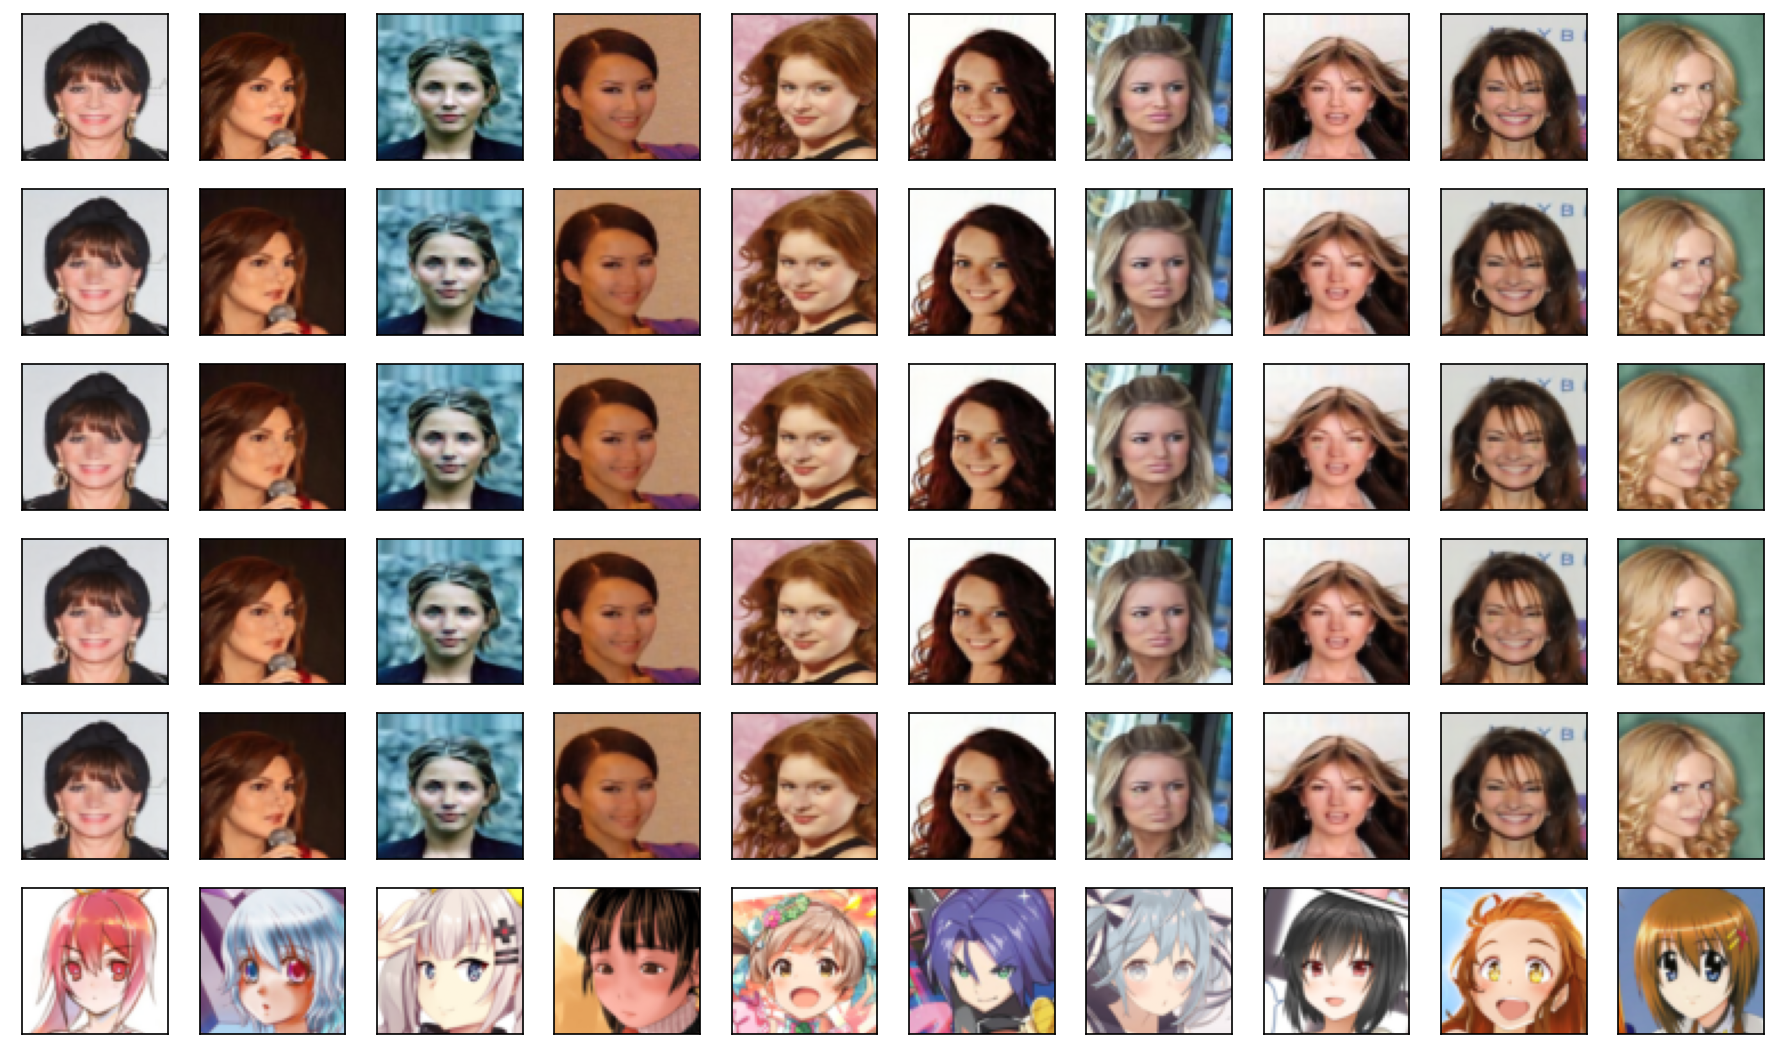

mode = test


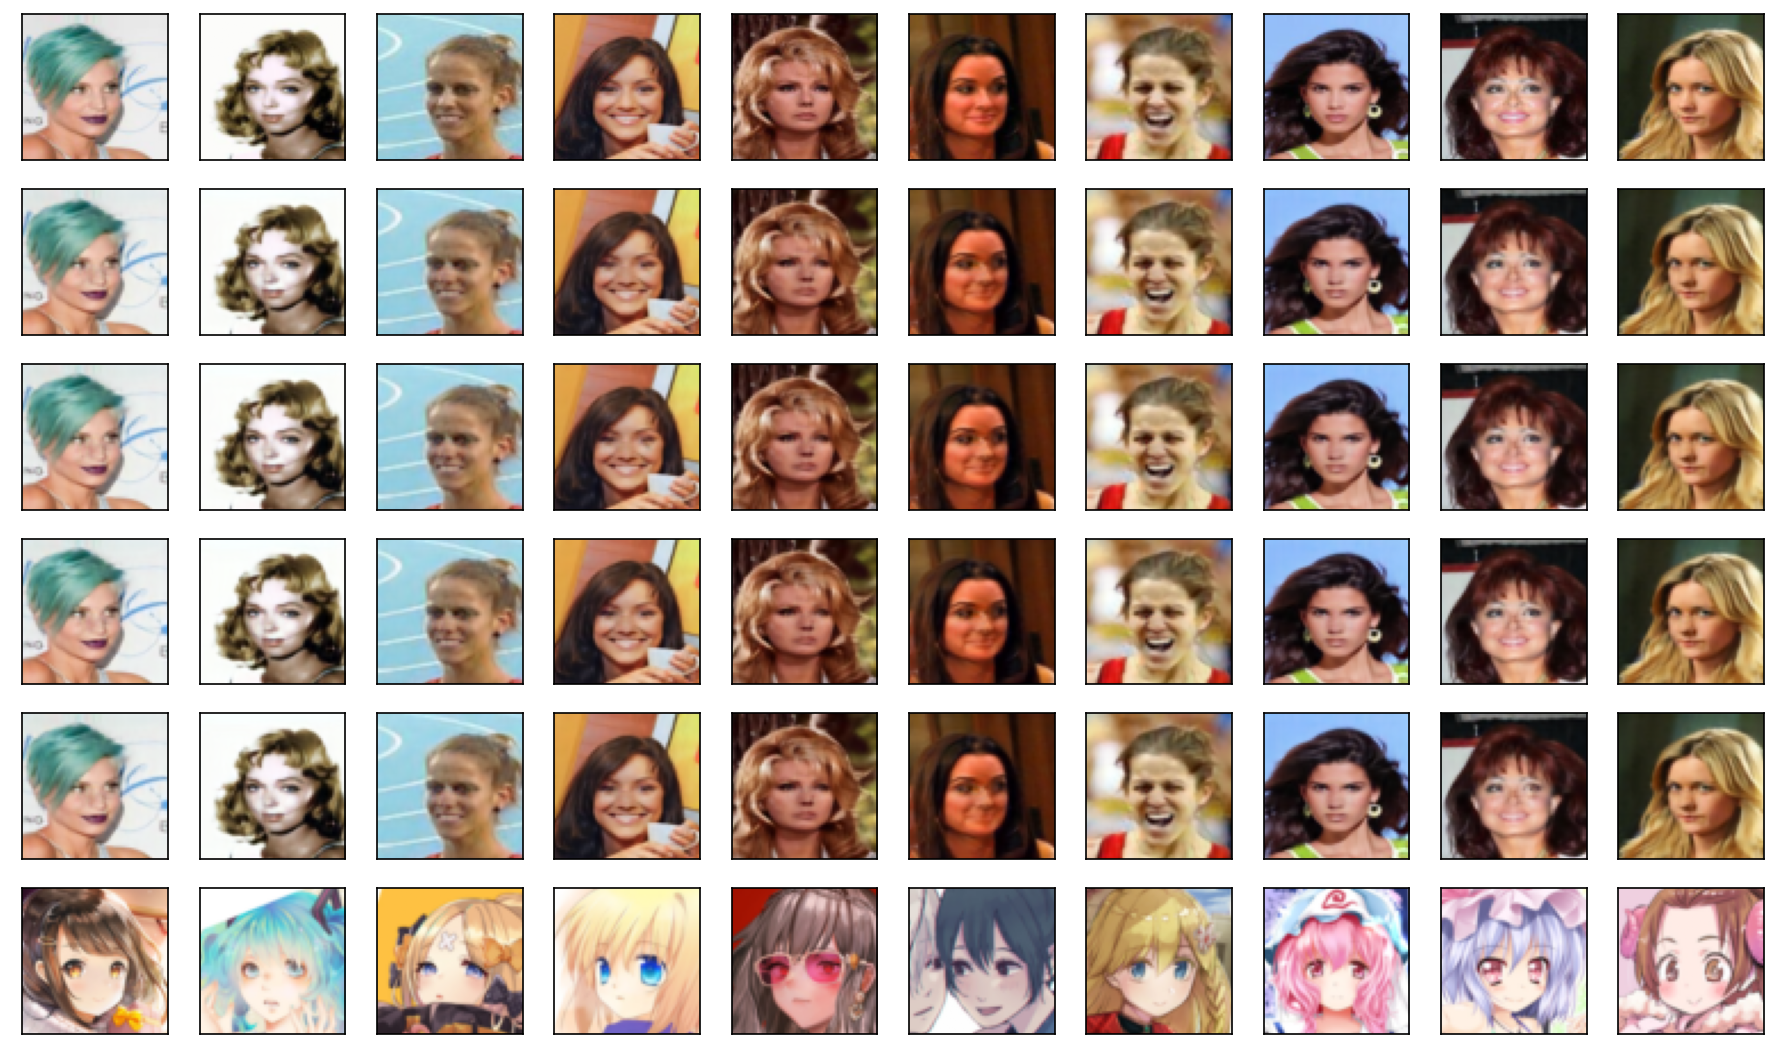

G loss = 18.282390594482422, d loss = 1.0262196063995361, lambda_id = 500.0
G loss = 19.852035522460938, d loss = 0.8322219252586365, lambda_id = 500.0
G loss = 20.78813934326172, d loss = 0.7727989554405212, lambda_id = 500.0
G loss = 20.99346160888672, d loss = 0.9174901247024536, lambda_id = 500.0
G loss = 20.27941131591797, d loss = 0.9333740472793579, lambda_id = 500.0
G loss = 20.752788543701172, d loss = 0.714277982711792, lambda_id = 500.0
G loss = 18.483108520507812, d loss = 1.2069361209869385, lambda_id = 500.0
G loss = 17.60173797607422, d loss = 1.0113515853881836, lambda_id = 500.0
G loss = 16.55851173400879, d loss = 1.01521635055542, lambda_id = 500.0
G loss = 19.402385711669922, d loss = 0.7763668894767761, lambda_id = 500.0
Elapsed time [1 day, 6:08:45], Iteration [96011/100000], D/latent_real: [0.3866] D/latent_fake: [0.3748] D/latent_reg: [0.0468] D/ref_real: [0.3026] D/ref_fake: [0.4282] D/ref_reg: [0.0456] G/latent_adv: [3.3586] G/latent_sty: [0.2579] G/latent_ds:

G loss = 20.92845344543457, d loss = 1.0108635425567627, lambda_id = 500.0
G loss = 17.36720085144043, d loss = 1.0782444477081299, lambda_id = 500.0
G loss = 18.196828842163086, d loss = 1.0007299184799194, lambda_id = 500.0
G loss = 19.6630802154541, d loss = 0.5987711548805237, lambda_id = 500.0
G loss = 18.335098266601562, d loss = 1.005803108215332, lambda_id = 500.0
G loss = 18.870800018310547, d loss = 0.8746269941329956, lambda_id = 500.0
Elapsed time [1 day, 6:10:02], Iteration [96081/100000], D/latent_real: [0.3501] D/latent_fake: [0.5469] D/latent_reg: [0.0571] D/ref_real: [0.4017] D/ref_fake: [0.4156] D/ref_reg: [0.0573] G/latent_adv: [2.6908] G/latent_sty: [0.2774] G/latent_ds: [0.0100] G/latent_cyc: [0.0525] G/ref_adv: [2.0716] G/ref_sty: [0.1354] G/ref_ds: [0.0221] G/ref_cyc: [0.0719] G/lambda_ds: [0.0392]
G loss = 18.164552688598633, d loss = 0.8337253332138062, lambda_id = 500.0
G loss = 18.89576530456543, d loss = 0.7626821994781494, lambda_id = 500.0
G loss = 19.8173

G loss = 18.800798416137695, d loss = 0.8361169695854187, lambda_id = 500.0
G loss = 18.475425720214844, d loss = 1.0519979000091553, lambda_id = 500.0
Elapsed time [1 day, 6:11:19], Iteration [96151/100000], D/latent_real: [0.3536] D/latent_fake: [0.6887] D/latent_reg: [0.0503] D/ref_real: [0.6041] D/ref_fake: [0.4001] D/ref_reg: [0.0478] G/latent_adv: [2.3757] G/latent_sty: [0.2306] G/latent_ds: [0.0152] G/latent_cyc: [0.0508] G/ref_adv: [1.8539] G/ref_sty: [0.2210] G/ref_ds: [0.0244] G/ref_cyc: [0.0795] G/lambda_ds: [0.0385]
G loss = 18.489011764526367, d loss = 0.8984233140945435, lambda_id = 500.0
G loss = 18.73219871520996, d loss = 0.9891403913497925, lambda_id = 500.0
G loss = 18.587434768676758, d loss = 0.8418644666671753, lambda_id = 500.0
G loss = 18.9693660736084, d loss = 0.8049018383026123, lambda_id = 500.0
G loss = 19.92034912109375, d loss = 0.7069104909896851, lambda_id = 500.0
G loss = 16.678123474121094, d loss = 1.0233625173568726, lambda_id = 500.0
G loss = 19.94

G loss = 18.375768661499023, d loss = 0.7655258178710938, lambda_id = 500.0
G loss = 17.344587326049805, d loss = 1.0670771598815918, lambda_id = 500.0
G loss = 21.48896598815918, d loss = 0.9937471151351929, lambda_id = 500.0
G loss = 18.67128562927246, d loss = 0.8594135642051697, lambda_id = 500.0
G loss = 17.059982299804688, d loss = 1.0211845636367798, lambda_id = 500.0
G loss = 16.692520141601562, d loss = 1.0493742227554321, lambda_id = 500.0
G loss = 17.319459915161133, d loss = 0.856518566608429, lambda_id = 500.0
G loss = 19.77495765686035, d loss = 0.9261592626571655, lambda_id = 500.0
G loss = 17.444015502929688, d loss = 1.0317838191986084, lambda_id = 500.0
G loss = 21.226837158203125, d loss = 0.8507212996482849, lambda_id = 500.0
Elapsed time [1 day, 6:12:47], Iteration [96231/100000], D/latent_real: [0.3130] D/latent_fake: [0.5662] D/latent_reg: [0.0553] D/ref_real: [0.4462] D/ref_fake: [0.3375] D/ref_reg: [0.0670] G/latent_adv: [2.9025] G/latent_sty: [0.2586] G/latent

G loss = 18.131622314453125, d loss = 0.9020559787750244, lambda_id = 500.0
G loss = 22.005678176879883, d loss = 0.7746743559837341, lambda_id = 500.0
G loss = 20.287090301513672, d loss = 0.8390604853630066, lambda_id = 500.0
G loss = 19.071313858032227, d loss = 1.0390145778656006, lambda_id = 500.0
G loss = 18.65184211730957, d loss = 0.8993124961853027, lambda_id = 500.0
G loss = 20.36530303955078, d loss = 0.9966782331466675, lambda_id = 500.0
Elapsed time [1 day, 6:14:03], Iteration [96301/100000], D/latent_real: [0.3981] D/latent_fake: [0.5782] D/latent_reg: [0.0583] D/ref_real: [0.5348] D/ref_fake: [0.4079] D/ref_reg: [0.0539] G/latent_adv: [2.1259] G/latent_sty: [0.2777] G/latent_ds: [0.0131] G/latent_cyc: [0.0582] G/ref_adv: [1.8942] G/ref_sty: [0.1974] G/ref_ds: [0.0266] G/ref_cyc: [0.0627] G/lambda_ds: [0.0370]
G loss = 19.546043395996094, d loss = 0.64931720495224, lambda_id = 500.0
G loss = 18.34010887145996, d loss = 1.019078254699707, lambda_id = 500.0
G loss = 21.0163

G loss = 19.762386322021484, d loss = 1.0610008239746094, lambda_id = 500.0
G loss = 16.772947311401367, d loss = 1.1051456928253174, lambda_id = 500.0
Elapsed time [1 day, 6:15:20], Iteration [96371/100000], D/latent_real: [0.3319] D/latent_fake: [0.8080] D/latent_reg: [0.0490] D/ref_real: [0.5469] D/ref_fake: [0.5031] D/ref_reg: [0.0552] G/latent_adv: [1.6251] G/latent_sty: [0.2511] G/latent_ds: [0.0095] G/latent_cyc: [0.0472] G/ref_adv: [1.2965] G/ref_sty: [0.1158] G/ref_ds: [0.0157] G/ref_cyc: [0.0636] G/lambda_ds: [0.0363]
G loss = 16.570959091186523, d loss = 0.7648491263389587, lambda_id = 500.0
G loss = 17.68998908996582, d loss = 0.9026791453361511, lambda_id = 500.0
G loss = 17.470787048339844, d loss = 0.9458988308906555, lambda_id = 500.0
G loss = 18.152687072753906, d loss = 1.032789707183838, lambda_id = 500.0
G loss = 22.155492782592773, d loss = 1.035300374031067, lambda_id = 500.0
G loss = 21.114404678344727, d loss = 0.9207331538200378, lambda_id = 500.0
G loss = 19.1

G loss = 17.23578453063965, d loss = 0.946368932723999, lambda_id = 500.0
G loss = 20.549489974975586, d loss = 0.6808963418006897, lambda_id = 500.0
G loss = 17.189353942871094, d loss = 0.8556351661682129, lambda_id = 500.0
G loss = 20.816274642944336, d loss = 0.8381787538528442, lambda_id = 500.0
G loss = 20.687477111816406, d loss = 0.7197567820549011, lambda_id = 500.0
G loss = 19.98878288269043, d loss = 0.8478899598121643, lambda_id = 500.0
G loss = 17.564617156982422, d loss = 0.8727045655250549, lambda_id = 500.0
G loss = 19.282743453979492, d loss = 0.8539263010025024, lambda_id = 500.0
G loss = 20.262168884277344, d loss = 0.6583025455474854, lambda_id = 500.0
G loss = 19.5097599029541, d loss = 0.9492657780647278, lambda_id = 500.0
Elapsed time [1 day, 6:16:48], Iteration [96451/100000], D/latent_real: [0.2601] D/latent_fake: [0.6410] D/latent_reg: [0.0513] D/ref_real: [0.6160] D/ref_fake: [0.2756] D/ref_reg: [0.0577] G/latent_adv: [2.5372] G/latent_sty: [0.2473] G/latent_

G loss = 18.942001342773438, d loss = 0.7217068076133728, lambda_id = 500.0
G loss = 19.808717727661133, d loss = 0.8538469076156616, lambda_id = 500.0
G loss = 20.847501754760742, d loss = 1.0945179462432861, lambda_id = 500.0
G loss = 21.156597137451172, d loss = 0.9065913558006287, lambda_id = 500.0
G loss = 21.603410720825195, d loss = 0.8668777942657471, lambda_id = 500.0
G loss = 20.34317970275879, d loss = 0.9877530932426453, lambda_id = 500.0
Elapsed time [1 day, 6:18:05], Iteration [96521/100000], D/latent_real: [0.5492] D/latent_fake: [0.4441] D/latent_reg: [0.0597] D/ref_real: [0.3172] D/ref_fake: [0.6231] D/ref_reg: [0.0474] G/latent_adv: [2.6644] G/latent_sty: [0.2623] G/latent_ds: [0.0116] G/latent_cyc: [0.0572] G/ref_adv: [2.3065] G/ref_sty: [0.1788] G/ref_ds: [0.0135] G/ref_cyc: [0.0631] G/lambda_ds: [0.0348]
G loss = 19.402996063232422, d loss = 0.8481225967407227, lambda_id = 500.0
G loss = 23.417997360229492, d loss = 0.9323042631149292, lambda_id = 500.0
G loss = 20

G loss = 17.04925537109375, d loss = 1.1436349153518677, lambda_id = 500.0
G loss = 17.35022735595703, d loss = 0.9102864265441895, lambda_id = 500.0
Elapsed time [1 day, 6:19:22], Iteration [96591/100000], D/latent_real: [0.3908] D/latent_fake: [0.4962] D/latent_reg: [0.0476] D/ref_real: [0.4114] D/ref_fake: [0.4468] D/ref_reg: [0.0521] G/latent_adv: [2.7435] G/latent_sty: [0.2303] G/latent_ds: [0.0097] G/latent_cyc: [0.0430] G/ref_adv: [2.6796] G/ref_sty: [0.2273] G/ref_ds: [0.0097] G/ref_cyc: [0.0503] G/lambda_ds: [0.0341]
G loss = 18.417699813842773, d loss = 0.7936450242996216, lambda_id = 500.0
G loss = 19.895050048828125, d loss = 0.8841195106506348, lambda_id = 500.0
G loss = 18.84994888305664, d loss = 0.936579167842865, lambda_id = 500.0
G loss = 19.627775192260742, d loss = 0.886416494846344, lambda_id = 500.0
G loss = 16.206256866455078, d loss = 0.9324274659156799, lambda_id = 500.0
G loss = 17.11553192138672, d loss = 0.981614351272583, lambda_id = 500.0
G loss = 20.39461

G loss = 17.43779182434082, d loss = 0.9628811478614807, lambda_id = 500.0
G loss = 19.458219528198242, d loss = 0.7701019644737244, lambda_id = 500.0
G loss = 20.6343936920166, d loss = 0.6732414960861206, lambda_id = 500.0
G loss = 17.81911277770996, d loss = 1.079976201057434, lambda_id = 500.0
G loss = 19.40310287475586, d loss = 0.817579448223114, lambda_id = 500.0
G loss = 18.927209854125977, d loss = 0.8645043969154358, lambda_id = 500.0
G loss = 18.152475357055664, d loss = 0.8512962460517883, lambda_id = 500.0
G loss = 19.771652221679688, d loss = 0.8714243173599243, lambda_id = 500.0
G loss = 18.72371482849121, d loss = 0.8397971987724304, lambda_id = 500.0
G loss = 19.641128540039062, d loss = 0.7996701598167419, lambda_id = 500.0
Elapsed time [1 day, 6:20:50], Iteration [96671/100000], D/latent_real: [0.3580] D/latent_fake: [0.4762] D/latent_reg: [0.0514] D/ref_real: [0.3185] D/ref_fake: [0.4314] D/ref_reg: [0.0498] G/latent_adv: [3.6338] G/latent_sty: [0.2447] G/latent_ds:

G loss = 20.62320899963379, d loss = 0.8590976595878601, lambda_id = 500.0
G loss = 20.600215911865234, d loss = 0.8957760334014893, lambda_id = 500.0
G loss = 20.302629470825195, d loss = 0.9437494874000549, lambda_id = 500.0
G loss = 18.969961166381836, d loss = 0.7922970652580261, lambda_id = 500.0
G loss = 20.536436080932617, d loss = 0.9179826974868774, lambda_id = 500.0
G loss = 21.8111572265625, d loss = 0.7985480427742004, lambda_id = 500.0
Elapsed time [1 day, 6:22:07], Iteration [96741/100000], D/latent_real: [0.3727] D/latent_fake: [0.4448] D/latent_reg: [0.0558] D/ref_real: [0.3670] D/ref_fake: [0.3781] D/ref_reg: [0.0535] G/latent_adv: [3.1638] G/latent_sty: [0.2425] G/latent_ds: [0.0126] G/latent_cyc: [0.0572] G/ref_adv: [2.8954] G/ref_sty: [0.1939] G/ref_ds: [0.0076] G/ref_cyc: [0.0942] G/lambda_ds: [0.0326]
G loss = 23.290708541870117, d loss = 0.842171847820282, lambda_id = 500.0
G loss = 18.659059524536133, d loss = 0.9022231698036194, lambda_id = 500.0
G loss = 18.15

G loss = 19.214962005615234, d loss = 1.1238619089126587, lambda_id = 500.0
G loss = 18.512784957885742, d loss = 0.9877350330352783, lambda_id = 500.0
Elapsed time [1 day, 6:23:24], Iteration [96811/100000], D/latent_real: [0.3861] D/latent_fake: [0.5783] D/latent_reg: [0.0513] D/ref_real: [0.4924] D/ref_fake: [0.4409] D/ref_reg: [0.0544] G/latent_adv: [2.2527] G/latent_sty: [0.2745] G/latent_ds: [0.0103] G/latent_cyc: [0.0508] G/ref_adv: [1.6484] G/ref_sty: [0.1845] G/ref_ds: [0.0130] G/ref_cyc: [0.0623] G/lambda_ds: [0.0319]
G loss = 20.254104614257812, d loss = 0.9211293458938599, lambda_id = 500.0
G loss = 19.104291915893555, d loss = 0.9099377989768982, lambda_id = 500.0
G loss = 17.392574310302734, d loss = 0.8872798085212708, lambda_id = 500.0
G loss = 21.868175506591797, d loss = 0.5617703199386597, lambda_id = 500.0
G loss = 20.38909339904785, d loss = 0.6868430972099304, lambda_id = 500.0
G loss = 18.33038330078125, d loss = 1.087162971496582, lambda_id = 500.0
G loss = 19.1

G loss = 18.87786865234375, d loss = 0.8778939247131348, lambda_id = 500.0
G loss = 19.563396453857422, d loss = 0.6461877226829529, lambda_id = 500.0
G loss = 19.384552001953125, d loss = 0.5294483304023743, lambda_id = 500.0
G loss = 19.983455657958984, d loss = 0.7993610501289368, lambda_id = 500.0
G loss = 18.71218490600586, d loss = 0.8466875553131104, lambda_id = 500.0
G loss = 17.885969161987305, d loss = 1.0684534311294556, lambda_id = 500.0
G loss = 21.664453506469727, d loss = 0.7855300307273865, lambda_id = 500.0
G loss = 18.859210968017578, d loss = 0.9104881286621094, lambda_id = 500.0
G loss = 18.325098037719727, d loss = 0.957503616809845, lambda_id = 500.0
G loss = 18.289020538330078, d loss = 1.0497997999191284, lambda_id = 500.0
Elapsed time [1 day, 6:24:52], Iteration [96891/100000], D/latent_real: [0.3557] D/latent_fake: [0.7941] D/latent_reg: [0.0503] D/ref_real: [0.5406] D/ref_fake: [0.4593] D/ref_reg: [0.0499] G/latent_adv: [1.7767] G/latent_sty: [0.2508] G/laten

G loss = 17.994569778442383, d loss = 1.0450794696807861, lambda_id = 500.0
G loss = 16.793027877807617, d loss = 1.1834595203399658, lambda_id = 500.0
G loss = 19.077760696411133, d loss = 1.0197218656539917, lambda_id = 500.0
G loss = 18.138444900512695, d loss = 0.9675229787826538, lambda_id = 500.0
G loss = 18.727924346923828, d loss = 0.8845533132553101, lambda_id = 500.0
G loss = 19.859188079833984, d loss = 0.9342833757400513, lambda_id = 500.0
Elapsed time [1 day, 6:26:09], Iteration [96961/100000], D/latent_real: [0.4134] D/latent_fake: [0.5353] D/latent_reg: [0.0602] D/ref_real: [0.4433] D/ref_fake: [0.4340] D/ref_reg: [0.0570] G/latent_adv: [2.8997] G/latent_sty: [0.2737] G/latent_ds: [0.0108] G/latent_cyc: [0.0585] G/ref_adv: [2.0803] G/ref_sty: [0.1472] G/ref_ds: [0.0212] G/ref_cyc: [0.0732] G/lambda_ds: [0.0304]
G loss = 20.64052963256836, d loss = 0.8677648901939392, lambda_id = 500.0
G loss = 18.947433471679688, d loss = 1.0193578004837036, lambda_id = 500.0
G loss = 17

G loss = 21.02410125732422, d loss = 0.956845223903656, lambda_id = 500.0
G loss = 17.412399291992188, d loss = 1.0554027557373047, lambda_id = 500.0
Elapsed time [1 day, 6:27:26], Iteration [97031/100000], D/latent_real: [0.4317] D/latent_fake: [0.5824] D/latent_reg: [0.0520] D/ref_real: [0.4530] D/ref_fake: [0.5495] D/ref_reg: [0.0529] G/latent_adv: [2.4088] G/latent_sty: [0.2669] G/latent_ds: [0.0113] G/latent_cyc: [0.0474] G/ref_adv: [1.8620] G/ref_sty: [0.1782] G/ref_ds: [0.0215] G/ref_cyc: [0.0664] G/lambda_ds: [0.0297]
G loss = 18.59444808959961, d loss = 0.918855607509613, lambda_id = 500.0
G loss = 21.280776977539062, d loss = 0.6175358295440674, lambda_id = 500.0
G loss = 18.033267974853516, d loss = 0.8867473006248474, lambda_id = 500.0
G loss = 20.77273178100586, d loss = 1.1303989887237549, lambda_id = 500.0
G loss = 21.219810485839844, d loss = 0.7789170145988464, lambda_id = 500.0
G loss = 18.733842849731445, d loss = 1.0824388265609741, lambda_id = 500.0
G loss = 17.950

G loss = 19.331905364990234, d loss = 1.02994966506958, lambda_id = 500.0
G loss = 17.62900161743164, d loss = 0.810113251209259, lambda_id = 500.0
G loss = 19.797592163085938, d loss = 1.0187170505523682, lambda_id = 500.0
G loss = 19.12140655517578, d loss = 1.0199074745178223, lambda_id = 500.0
G loss = 20.1116886138916, d loss = 0.8932276368141174, lambda_id = 500.0
G loss = 24.76897430419922, d loss = 0.6568465828895569, lambda_id = 500.0
G loss = 19.816871643066406, d loss = 0.7931057214736938, lambda_id = 500.0
G loss = 23.27462387084961, d loss = 0.7414767146110535, lambda_id = 500.0
G loss = 19.29851722717285, d loss = 1.0559943914413452, lambda_id = 500.0
G loss = 18.56373405456543, d loss = 1.1048088073730469, lambda_id = 500.0
Elapsed time [1 day, 6:28:54], Iteration [97111/100000], D/latent_real: [0.3102] D/latent_fake: [0.8263] D/latent_reg: [0.0487] D/ref_real: [0.6307] D/ref_fake: [0.4176] D/ref_reg: [0.0565] G/latent_adv: [1.8539] G/latent_sty: [0.2491] G/latent_ds: [0

G loss = 18.582223892211914, d loss = 0.9693673253059387, lambda_id = 500.0
G loss = 19.004623413085938, d loss = 0.8576721549034119, lambda_id = 500.0
G loss = 20.45356559753418, d loss = 0.7722527980804443, lambda_id = 500.0
G loss = 19.381925582885742, d loss = 0.7046077251434326, lambda_id = 500.0
G loss = 19.387287139892578, d loss = 0.8993203639984131, lambda_id = 500.0
G loss = 20.075361251831055, d loss = 0.6514632701873779, lambda_id = 500.0
Elapsed time [1 day, 6:30:10], Iteration [97181/100000], D/latent_real: [0.3303] D/latent_fake: [0.3249] D/latent_reg: [0.0616] D/ref_real: [0.2482] D/ref_fake: [0.3445] D/ref_reg: [0.0588] G/latent_adv: [3.9256] G/latent_sty: [0.2641] G/latent_ds: [0.0114] G/latent_cyc: [0.0483] G/ref_adv: [3.2099] G/ref_sty: [0.1777] G/ref_ds: [0.0339] G/ref_cyc: [0.0616] G/lambda_ds: [0.0282]
G loss = 18.536479949951172, d loss = 1.047091007232666, lambda_id = 500.0
G loss = 17.886987686157227, d loss = 0.963699460029602, lambda_id = 500.0
G loss = 21.2

G loss = 21.62023162841797, d loss = 0.9115613102912903, lambda_id = 500.0
G loss = 20.427656173706055, d loss = 0.7222587466239929, lambda_id = 500.0
Elapsed time [1 day, 6:31:27], Iteration [97251/100000], D/latent_real: [0.4807] D/latent_fake: [0.2485] D/latent_reg: [0.0509] D/ref_real: [0.2247] D/ref_fake: [0.4533] D/ref_reg: [0.0443] G/latent_adv: [3.9714] G/latent_sty: [0.2951] G/latent_ds: [0.0115] G/latent_cyc: [0.0520] G/ref_adv: [2.8834] G/ref_sty: [0.2001] G/ref_ds: [0.0338] G/ref_cyc: [0.0785] G/lambda_ds: [0.0275]
G loss = 21.29273223876953, d loss = 0.7532814145088196, lambda_id = 500.0
G loss = 20.367019653320312, d loss = 0.7076647877693176, lambda_id = 500.0
G loss = 20.05609893798828, d loss = 0.9329325556755066, lambda_id = 500.0
G loss = 20.700103759765625, d loss = 0.8159074783325195, lambda_id = 500.0
G loss = 19.68284034729004, d loss = 0.935791552066803, lambda_id = 500.0
G loss = 22.43671226501465, d loss = 0.8138212561607361, lambda_id = 500.0
G loss = 16.9907

G loss = 19.189435958862305, d loss = 1.0057084560394287, lambda_id = 500.0
G loss = 17.57180404663086, d loss = 0.9721997380256653, lambda_id = 500.0
G loss = 17.611764907836914, d loss = 0.9980652928352356, lambda_id = 500.0
G loss = 16.762893676757812, d loss = 0.8752744793891907, lambda_id = 500.0
G loss = 18.906436920166016, d loss = 0.909950315952301, lambda_id = 500.0
G loss = 19.173471450805664, d loss = 0.9683725833892822, lambda_id = 500.0
G loss = 20.271808624267578, d loss = 0.8254175186157227, lambda_id = 500.0
G loss = 17.11418342590332, d loss = 0.9937151670455933, lambda_id = 500.0
G loss = 18.760089874267578, d loss = 0.8624920845031738, lambda_id = 500.0
G loss = 18.540475845336914, d loss = 0.8818252682685852, lambda_id = 500.0
Elapsed time [1 day, 6:32:55], Iteration [97331/100000], D/latent_real: [0.4416] D/latent_fake: [0.5117] D/latent_reg: [0.0713] D/ref_real: [0.4245] D/ref_fake: [0.3951] D/ref_reg: [0.0623] G/latent_adv: [2.6218] G/latent_sty: [0.2726] G/laten

G loss = 20.528583526611328, d loss = 0.9543104767799377, lambda_id = 500.0
G loss = 20.726318359375, d loss = 0.9570030570030212, lambda_id = 500.0
G loss = 19.702045440673828, d loss = 0.8512295484542847, lambda_id = 500.0
G loss = 21.320796966552734, d loss = 0.8827491402626038, lambda_id = 500.0
G loss = 20.199493408203125, d loss = 0.8684345483779907, lambda_id = 500.0
G loss = 18.815420150756836, d loss = 0.6903930306434631, lambda_id = 500.0
Elapsed time [1 day, 6:34:12], Iteration [97401/100000], D/latent_real: [0.3218] D/latent_fake: [0.4610] D/latent_reg: [0.0601] D/ref_real: [0.2976] D/ref_fake: [0.3434] D/ref_reg: [0.0494] G/latent_adv: [3.5184] G/latent_sty: [0.2348] G/latent_ds: [0.0111] G/latent_cyc: [0.0463] G/ref_adv: [2.9970] G/ref_sty: [0.1823] G/ref_ds: [0.0114] G/ref_cyc: [0.0607] G/lambda_ds: [0.0260]
G loss = 20.51217269897461, d loss = 0.6925964951515198, lambda_id = 500.0
G loss = 18.390827178955078, d loss = 1.2128996849060059, lambda_id = 500.0
G loss = 18.56

G loss = 19.332168579101562, d loss = 0.9469900727272034, lambda_id = 500.0
G loss = 19.015390396118164, d loss = 1.0515751838684082, lambda_id = 500.0
Elapsed time [1 day, 6:35:29], Iteration [97471/100000], D/latent_real: [0.4166] D/latent_fake: [0.6234] D/latent_reg: [0.0590] D/ref_real: [0.5158] D/ref_fake: [0.4820] D/ref_reg: [0.0538] G/latent_adv: [2.4400] G/latent_sty: [0.2330] G/latent_ds: [0.0128] G/latent_cyc: [0.0534] G/ref_adv: [1.9862] G/ref_sty: [0.1617] G/ref_ds: [0.0231] G/ref_cyc: [0.0670] G/lambda_ds: [0.0253]
G loss = 19.750633239746094, d loss = 0.8054078221321106, lambda_id = 500.0
G loss = 19.506629943847656, d loss = 0.8859968781471252, lambda_id = 500.0
G loss = 21.381479263305664, d loss = 1.1046419143676758, lambda_id = 500.0
G loss = 22.473609924316406, d loss = 0.8377201557159424, lambda_id = 500.0
G loss = 20.328887939453125, d loss = 0.9394789338111877, lambda_id = 500.0
G loss = 22.668354034423828, d loss = 0.42616838216781616, lambda_id = 500.0
G loss = 

G loss = 21.13338851928711, d loss = 0.5882768630981445, lambda_id = 500.0
G loss = 19.782562255859375, d loss = 1.0923378467559814, lambda_id = 500.0
G loss = 20.555328369140625, d loss = 0.7995102405548096, lambda_id = 500.0
G loss = 17.2587890625, d loss = 1.3122384548187256, lambda_id = 500.0
G loss = 18.504701614379883, d loss = 0.9143518805503845, lambda_id = 500.0
G loss = 24.16069984436035, d loss = 0.7849738001823425, lambda_id = 500.0
G loss = 18.270544052124023, d loss = 0.8699324727058411, lambda_id = 500.0
G loss = 17.231111526489258, d loss = 1.1731945276260376, lambda_id = 500.0
G loss = 20.378843307495117, d loss = 0.7523396611213684, lambda_id = 500.0
G loss = 19.942508697509766, d loss = 0.6791217923164368, lambda_id = 500.0
Elapsed time [1 day, 6:36:57], Iteration [97551/100000], D/latent_real: [0.3101] D/latent_fake: [0.4005] D/latent_reg: [0.0491] D/ref_real: [0.2831] D/ref_fake: [0.3494] D/ref_reg: [0.0466] G/latent_adv: [3.4590] G/latent_sty: [0.2345] G/latent_ds

G loss = 17.903545379638672, d loss = 0.7559375762939453, lambda_id = 500.0
G loss = 17.96790313720703, d loss = 0.8313121199607849, lambda_id = 500.0
G loss = 17.332088470458984, d loss = 1.1884406805038452, lambda_id = 500.0
G loss = 18.233476638793945, d loss = 0.9884610772132874, lambda_id = 500.0
G loss = 18.116321563720703, d loss = 0.9362733364105225, lambda_id = 500.0
G loss = 17.846174240112305, d loss = 1.036301851272583, lambda_id = 500.0
Elapsed time [1 day, 6:38:14], Iteration [97621/100000], D/latent_real: [0.4230] D/latent_fake: [0.5923] D/latent_reg: [0.0526] D/ref_real: [0.5047] D/ref_fake: [0.4753] D/ref_reg: [0.0564] G/latent_adv: [1.9953] G/latent_sty: [0.2415] G/latent_ds: [0.0102] G/latent_cyc: [0.0505] G/ref_adv: [1.7984] G/ref_sty: [0.2329] G/ref_ds: [0.0112] G/ref_cyc: [0.0619] G/lambda_ds: [0.0238]
G loss = 20.521520614624023, d loss = 0.9347052574157715, lambda_id = 500.0
G loss = 19.78721046447754, d loss = 0.7785025238990784, lambda_id = 500.0
G loss = 19.2

G loss = 17.08258819580078, d loss = 0.9592080116271973, lambda_id = 500.0
G loss = 19.682756423950195, d loss = 0.7302897572517395, lambda_id = 500.0
Elapsed time [1 day, 6:39:31], Iteration [97691/100000], D/latent_real: [0.4453] D/latent_fake: [0.2957] D/latent_reg: [0.0604] D/ref_real: [0.2495] D/ref_fake: [0.4334] D/ref_reg: [0.0474] G/latent_adv: [3.8751] G/latent_sty: [0.2628] G/latent_ds: [0.0133] G/latent_cyc: [0.0489] G/ref_adv: [3.3936] G/ref_sty: [0.2393] G/ref_ds: [0.0180] G/ref_cyc: [0.0515] G/lambda_ds: [0.0231]
G loss = 19.9494571685791, d loss = 0.8327031135559082, lambda_id = 500.0
G loss = 18.091327667236328, d loss = 0.9048856496810913, lambda_id = 500.0
G loss = 19.161523818969727, d loss = 0.8968493938446045, lambda_id = 500.0
G loss = 21.90635871887207, d loss = 0.7272775173187256, lambda_id = 500.0
G loss = 22.093828201293945, d loss = 0.8868873715400696, lambda_id = 500.0
G loss = 18.473295211791992, d loss = 0.9341230392456055, lambda_id = 500.0
G loss = 19.39

G loss = 19.375579833984375, d loss = 0.537588357925415, lambda_id = 500.0
G loss = 18.02665138244629, d loss = 0.9892622828483582, lambda_id = 500.0
G loss = 19.433073043823242, d loss = 1.0607002973556519, lambda_id = 500.0
G loss = 19.771154403686523, d loss = 0.9857971668243408, lambda_id = 500.0
G loss = 18.720481872558594, d loss = 1.0190027952194214, lambda_id = 500.0
G loss = 18.30820083618164, d loss = 0.8513851165771484, lambda_id = 500.0
G loss = 19.236528396606445, d loss = 0.779902458190918, lambda_id = 500.0
G loss = 20.8372745513916, d loss = 0.8091748356819153, lambda_id = 500.0
G loss = 18.052690505981445, d loss = 1.1071898937225342, lambda_id = 500.0
G loss = 20.37511444091797, d loss = 0.7718895077705383, lambda_id = 500.0
Elapsed time [1 day, 6:40:59], Iteration [97771/100000], D/latent_real: [0.4055] D/latent_fake: [0.3391] D/latent_reg: [0.0652] D/ref_real: [0.2895] D/ref_fake: [0.4282] D/ref_reg: [0.0542] G/latent_adv: [3.9359] G/latent_sty: [0.2749] G/latent_ds

G loss = 21.510643005371094, d loss = 0.832492470741272, lambda_id = 500.0
G loss = 18.197647094726562, d loss = 1.0012708902359009, lambda_id = 500.0
G loss = 21.996212005615234, d loss = 0.841975748538971, lambda_id = 500.0
G loss = 20.402318954467773, d loss = 0.875746488571167, lambda_id = 500.0
G loss = 19.760316848754883, d loss = 0.7851744890213013, lambda_id = 500.0
G loss = 22.18160629272461, d loss = 0.9619589447975159, lambda_id = 500.0
Elapsed time [1 day, 6:42:16], Iteration [97841/100000], D/latent_real: [0.3625] D/latent_fake: [0.5564] D/latent_reg: [0.0560] D/ref_real: [0.5273] D/ref_fake: [0.3822] D/ref_reg: [0.0524] G/latent_adv: [2.9675] G/latent_sty: [0.2413] G/latent_ds: [0.0122] G/latent_cyc: [0.0581] G/ref_adv: [2.8461] G/ref_sty: [0.3086] G/ref_ds: [0.0115] G/ref_cyc: [0.0642] G/lambda_ds: [0.0216]
G loss = 18.270523071289062, d loss = 0.8212089538574219, lambda_id = 500.0
G loss = 19.269699096679688, d loss = 0.8022636771202087, lambda_id = 500.0
G loss = 18.12

G loss = 18.71832275390625, d loss = 0.7353342771530151, lambda_id = 500.0
G loss = 19.169727325439453, d loss = 0.6766003370285034, lambda_id = 500.0
Elapsed time [1 day, 6:43:33], Iteration [97911/100000], D/latent_real: [0.2474] D/latent_fake: [0.4988] D/latent_reg: [0.0548] D/ref_real: [0.2678] D/ref_fake: [0.3593] D/ref_reg: [0.0495] G/latent_adv: [3.6666] G/latent_sty: [0.2543] G/latent_ds: [0.0107] G/latent_cyc: [0.0493] G/ref_adv: [3.3767] G/ref_sty: [0.1929] G/ref_ds: [0.0309] G/ref_cyc: [0.0545] G/lambda_ds: [0.0209]
G loss = 19.792247772216797, d loss = 0.7400258183479309, lambda_id = 500.0
G loss = 20.980369567871094, d loss = 0.8034830093383789, lambda_id = 500.0
G loss = 20.09988021850586, d loss = 0.7660178542137146, lambda_id = 500.0
G loss = 20.549230575561523, d loss = 0.965928316116333, lambda_id = 500.0
G loss = 19.951135635375977, d loss = 0.8862732648849487, lambda_id = 500.0
G loss = 18.1268253326416, d loss = 0.9912261962890625, lambda_id = 500.0
G loss = 20.126

G loss = 20.969852447509766, d loss = 1.12998366355896, lambda_id = 500.0
G loss = 21.786945343017578, d loss = 1.0202094316482544, lambda_id = 500.0
G loss = 18.81540298461914, d loss = 0.9503782391548157, lambda_id = 500.0
G loss = 20.85528564453125, d loss = 0.7651980519294739, lambda_id = 500.0
G loss = 18.80641746520996, d loss = 0.9112548828125, lambda_id = 500.0
G loss = 20.079010009765625, d loss = 0.7800182104110718, lambda_id = 500.0
G loss = 19.33562469482422, d loss = 0.9368338584899902, lambda_id = 500.0
G loss = 17.655799865722656, d loss = 0.7915948629379272, lambda_id = 500.0
G loss = 18.506099700927734, d loss = 0.8853304386138916, lambda_id = 500.0
G loss = 20.719892501831055, d loss = 0.6972721219062805, lambda_id = 500.0
Elapsed time [1 day, 6:45:01], Iteration [97991/100000], D/latent_real: [0.3734] D/latent_fake: [0.3354] D/latent_reg: [0.0565] D/ref_real: [0.2682] D/ref_fake: [0.3811] D/ref_reg: [0.0479] G/latent_adv: [4.0109] G/latent_sty: [0.2715] G/latent_ds: 

G loss = 20.070173263549805, d loss = 0.8400144577026367, lambda_id = 500.0
G loss = 17.61597442626953, d loss = 0.9533565640449524, lambda_id = 500.0
G loss = 18.410160064697266, d loss = 0.7469443082809448, lambda_id = 500.0
G loss = 20.629131317138672, d loss = 0.819839596748352, lambda_id = 500.0
G loss = 17.25734519958496, d loss = 1.0007827281951904, lambda_id = 500.0
G loss = 20.036909103393555, d loss = 0.7104268670082092, lambda_id = 500.0
Elapsed time [1 day, 6:46:18], Iteration [98061/100000], D/latent_real: [0.3268] D/latent_fake: [0.3704] D/latent_reg: [0.0483] D/ref_real: [0.2824] D/ref_fake: [0.3832] D/ref_reg: [0.0448] G/latent_adv: [3.8162] G/latent_sty: [0.2696] G/latent_ds: [0.0140] G/latent_cyc: [0.0459] G/ref_adv: [2.9267] G/ref_sty: [0.2035] G/ref_ds: [0.0186] G/ref_cyc: [0.0584] G/lambda_ds: [0.0194]
G loss = 14.446233749389648, d loss = 1.2198023796081543, lambda_id = 500.0
G loss = 19.24013900756836, d loss = 0.9836912751197815, lambda_id = 500.0
G loss = 18.88

G loss = 20.869956970214844, d loss = 0.9640852808952332, lambda_id = 500.0
G loss = 19.7608699798584, d loss = 1.0043858289718628, lambda_id = 500.0
Elapsed time [1 day, 6:47:35], Iteration [98131/100000], D/latent_real: [0.3899] D/latent_fake: [0.5204] D/latent_reg: [0.0585] D/ref_real: [0.4115] D/ref_fake: [0.5330] D/ref_reg: [0.0599] G/latent_adv: [3.0095] G/latent_sty: [0.2452] G/latent_ds: [0.0100] G/latent_cyc: [0.0477] G/ref_adv: [1.9601] G/ref_sty: [0.1693] G/ref_ds: [0.0234] G/ref_cyc: [0.0731] G/lambda_ds: [0.0187]
G loss = 20.349239349365234, d loss = 0.7865492105484009, lambda_id = 500.0
G loss = 17.35885238647461, d loss = 1.0385680198669434, lambda_id = 500.0
G loss = 18.36307716369629, d loss = 0.9827500581741333, lambda_id = 500.0
G loss = 18.21234130859375, d loss = 0.9992920160293579, lambda_id = 500.0
G loss = 23.65422821044922, d loss = 0.6804545521736145, lambda_id = 500.0
G loss = 17.974773406982422, d loss = 1.0525795221328735, lambda_id = 500.0
G loss = 20.9571

G loss = 17.82526969909668, d loss = 1.076406478881836, lambda_id = 500.0
G loss = 18.83641242980957, d loss = 0.7988758683204651, lambda_id = 500.0
G loss = 19.688016891479492, d loss = 0.9111471176147461, lambda_id = 500.0
G loss = 22.091842651367188, d loss = 0.6848387718200684, lambda_id = 500.0
G loss = 19.0354061126709, d loss = 0.8140524625778198, lambda_id = 500.0
G loss = 20.02880859375, d loss = 0.9389966130256653, lambda_id = 500.0
G loss = 17.73431396484375, d loss = 0.9613417387008667, lambda_id = 500.0
G loss = 17.73196792602539, d loss = 1.0463305711746216, lambda_id = 500.0
G loss = 18.005590438842773, d loss = 1.0340076684951782, lambda_id = 500.0
G loss = 18.631807327270508, d loss = 0.6102453470230103, lambda_id = 500.0
Elapsed time [1 day, 6:49:02], Iteration [98211/100000], D/latent_real: [0.3536] D/latent_fake: [0.2472] D/latent_reg: [0.0392] D/ref_real: [0.2414] D/ref_fake: [0.3295] D/ref_reg: [0.0393] G/latent_adv: [4.2686] G/latent_sty: [0.2329] G/latent_ds: [0

G loss = 16.8555965423584, d loss = 0.990994393825531, lambda_id = 500.0
G loss = 17.027042388916016, d loss = 0.7947967648506165, lambda_id = 500.0
G loss = 19.683427810668945, d loss = 0.8114813566207886, lambda_id = 500.0
G loss = 17.192047119140625, d loss = 0.8766005635261536, lambda_id = 500.0
G loss = 19.286096572875977, d loss = 1.0538663864135742, lambda_id = 500.0
G loss = 18.921131134033203, d loss = 0.9157940149307251, lambda_id = 500.0
Elapsed time [1 day, 6:50:19], Iteration [98281/100000], D/latent_real: [0.4802] D/latent_fake: [0.3928] D/latent_reg: [0.0576] D/ref_real: [0.3007] D/ref_fake: [0.5555] D/ref_reg: [0.0596] G/latent_adv: [2.9634] G/latent_sty: [0.2985] G/latent_ds: [0.0136] G/latent_cyc: [0.0505] G/ref_adv: [2.2704] G/ref_sty: [0.2220] G/ref_ds: [0.0277] G/ref_cyc: [0.0859] G/lambda_ds: [0.0172]
G loss = 22.195537567138672, d loss = 0.6593074798583984, lambda_id = 500.0
G loss = 18.750328063964844, d loss = 0.881253719329834, lambda_id = 500.0
G loss = 18.28

G loss = 21.13483238220215, d loss = 0.7713034749031067, lambda_id = 500.0
G loss = 20.58173179626465, d loss = 0.466741144657135, lambda_id = 500.0
Elapsed time [1 day, 6:51:36], Iteration [98351/100000], D/latent_real: [0.2432] D/latent_fake: [0.3216] D/latent_reg: [0.0691] D/ref_real: [0.1832] D/ref_fake: [0.2417] D/ref_reg: [0.0418] G/latent_adv: [4.0948] G/latent_sty: [0.2532] G/latent_ds: [0.0110] G/latent_cyc: [0.0513] G/ref_adv: [3.0750] G/ref_sty: [0.1513] G/ref_ds: [0.0362] G/ref_cyc: [0.0637] G/lambda_ds: [0.0165]
G loss = 18.846054077148438, d loss = 0.8955248594284058, lambda_id = 500.0
G loss = 20.27189064025879, d loss = 0.8813512325286865, lambda_id = 500.0
G loss = 18.228803634643555, d loss = 0.9599129557609558, lambda_id = 500.0
G loss = 19.766822814941406, d loss = 0.8394938707351685, lambda_id = 500.0
G loss = 19.052289962768555, d loss = 0.9531140327453613, lambda_id = 500.0
G loss = 17.955427169799805, d loss = 0.9596283435821533, lambda_id = 500.0
G loss = 20.32

G loss = 15.161581039428711, d loss = 0.9832080602645874, lambda_id = 500.0
G loss = 15.649423599243164, d loss = 0.8950620293617249, lambda_id = 500.0
G loss = 17.724374771118164, d loss = 0.8046557903289795, lambda_id = 500.0
G loss = 17.379446029663086, d loss = 0.8928466439247131, lambda_id = 500.0
G loss = 18.700916290283203, d loss = 0.7984668612480164, lambda_id = 500.0
G loss = 16.737648010253906, d loss = 1.0584968328475952, lambda_id = 500.0
G loss = 18.1059627532959, d loss = 0.9863139986991882, lambda_id = 500.0
G loss = 21.213764190673828, d loss = 0.870758056640625, lambda_id = 500.0
G loss = 17.84743881225586, d loss = 1.0627793073654175, lambda_id = 500.0
G loss = 21.588756561279297, d loss = 0.907958447933197, lambda_id = 500.0
Elapsed time [1 day, 6:53:04], Iteration [98431/100000], D/latent_real: [0.5080] D/latent_fake: [0.3969] D/latent_reg: [0.0662] D/ref_real: [0.3156] D/ref_fake: [0.5445] D/ref_reg: [0.0478] G/latent_adv: [2.9702] G/latent_sty: [0.2654] G/latent_

G loss = 17.857528686523438, d loss = 1.0467579364776611, lambda_id = 500.0
G loss = 19.763729095458984, d loss = 0.8085598945617676, lambda_id = 500.0
G loss = 19.4183406829834, d loss = 1.0364413261413574, lambda_id = 500.0
G loss = 19.965166091918945, d loss = 0.7726391553878784, lambda_id = 500.0
G loss = 19.38062858581543, d loss = 0.9231439828872681, lambda_id = 500.0
G loss = 17.57738494873047, d loss = 1.09102463722229, lambda_id = 500.0
Elapsed time [1 day, 6:54:21], Iteration [98501/100000], D/latent_real: [0.3524] D/latent_fake: [0.7884] D/latent_reg: [0.0444] D/ref_real: [0.6002] D/ref_fake: [0.4402] D/ref_reg: [0.0506] G/latent_adv: [1.8399] G/latent_sty: [0.2503] G/latent_ds: [0.0098] G/latent_cyc: [0.0505] G/ref_adv: [1.6299] G/ref_sty: [0.1835] G/ref_ds: [0.0134] G/ref_cyc: [0.0556] G/lambda_ds: [0.0150]
G loss = 17.239891052246094, d loss = 1.0650153160095215, lambda_id = 500.0
G loss = 17.269010543823242, d loss = 0.8987680077552795, lambda_id = 500.0
G loss = 17.0729

G loss = 18.146020889282227, d loss = 0.8733882904052734, lambda_id = 500.0
G loss = 17.886877059936523, d loss = 1.0947264432907104, lambda_id = 500.0
Elapsed time [1 day, 6:55:38], Iteration [98571/100000], D/latent_real: [0.3922] D/latent_fake: [0.5815] D/latent_reg: [0.0635] D/ref_real: [0.5962] D/ref_fake: [0.4221] D/ref_reg: [0.0764] G/latent_adv: [2.2942] G/latent_sty: [0.2404] G/latent_ds: [0.0105] G/latent_cyc: [0.0653] G/ref_adv: [1.3686] G/ref_sty: [0.1267] G/ref_ds: [0.0370] G/ref_cyc: [0.0915] G/lambda_ds: [0.0143]
G loss = 19.294864654541016, d loss = 0.889766275882721, lambda_id = 500.0
G loss = 17.68262481689453, d loss = 0.9867583513259888, lambda_id = 500.0
G loss = 19.866365432739258, d loss = 0.8372490406036377, lambda_id = 500.0
G loss = 17.73716926574707, d loss = 0.8935784101486206, lambda_id = 500.0
G loss = 18.22532844543457, d loss = 0.8405339121818542, lambda_id = 500.0
G loss = 16.256229400634766, d loss = 1.0981804132461548, lambda_id = 500.0
G loss = 18.21

G loss = 21.439624786376953, d loss = 0.7904762029647827, lambda_id = 500.0
G loss = 16.183692932128906, d loss = 1.111724853515625, lambda_id = 500.0
G loss = 18.872957229614258, d loss = 0.9711549282073975, lambda_id = 500.0
G loss = 17.53851890563965, d loss = 0.9858022928237915, lambda_id = 500.0
G loss = 18.353565216064453, d loss = 0.8616779446601868, lambda_id = 500.0
G loss = 23.714763641357422, d loss = 0.8865835070610046, lambda_id = 500.0
G loss = 20.38201141357422, d loss = 0.9605968594551086, lambda_id = 500.0
G loss = 19.920108795166016, d loss = 0.9046390056610107, lambda_id = 500.0
G loss = 21.893020629882812, d loss = 0.8323870301246643, lambda_id = 500.0
G loss = 20.92758560180664, d loss = 0.8747186064720154, lambda_id = 500.0
Elapsed time [1 day, 6:57:06], Iteration [98651/100000], D/latent_real: [0.4416] D/latent_fake: [0.4471] D/latent_reg: [0.0590] D/ref_real: [0.3483] D/ref_fake: [0.4730] D/ref_reg: [0.0534] G/latent_adv: [3.0417] G/latent_sty: [0.2547] G/latent

G loss = 17.276870727539062, d loss = 0.9091804623603821, lambda_id = 500.0
G loss = 17.975873947143555, d loss = 0.8419876098632812, lambda_id = 500.0
G loss = 19.669321060180664, d loss = 0.7612072825431824, lambda_id = 500.0
G loss = 18.80583381652832, d loss = 0.8978378772735596, lambda_id = 500.0
G loss = 21.246646881103516, d loss = 0.8675364851951599, lambda_id = 500.0
G loss = 16.82008934020996, d loss = 1.0731652975082397, lambda_id = 500.0
Elapsed time [1 day, 6:58:23], Iteration [98721/100000], D/latent_real: [0.3142] D/latent_fake: [0.7841] D/latent_reg: [0.0573] D/ref_real: [0.6217] D/ref_fake: [0.3933] D/ref_reg: [0.0582] G/latent_adv: [2.0419] G/latent_sty: [0.2544] G/latent_ds: [0.0095] G/latent_cyc: [0.0469] G/ref_adv: [1.6840] G/ref_sty: [0.1374] G/ref_ds: [0.0212] G/ref_cyc: [0.0586] G/lambda_ds: [0.0128]
G loss = 18.22006607055664, d loss = 0.9939347505569458, lambda_id = 500.0
G loss = 17.841777801513672, d loss = 1.0180572271347046, lambda_id = 500.0
G loss = 19.3

G loss = 20.877962112426758, d loss = 0.7969757318496704, lambda_id = 500.0
G loss = 20.822551727294922, d loss = 0.8322628736495972, lambda_id = 500.0
Elapsed time [1 day, 6:59:40], Iteration [98791/100000], D/latent_real: [0.3001] D/latent_fake: [0.5027] D/latent_reg: [0.0556] D/ref_real: [0.4718] D/ref_fake: [0.3008] D/ref_reg: [0.0596] G/latent_adv: [2.9499] G/latent_sty: [0.2483] G/latent_ds: [0.0117] G/latent_cyc: [0.0543] G/ref_adv: [2.5096] G/ref_sty: [0.1519] G/ref_ds: [0.0344] G/ref_cyc: [0.0622] G/lambda_ds: [0.0121]
G loss = 18.808109283447266, d loss = 0.8257091045379639, lambda_id = 500.0
G loss = 18.380352020263672, d loss = 0.8906652927398682, lambda_id = 500.0
G loss = 19.461875915527344, d loss = 0.9193262457847595, lambda_id = 500.0
G loss = 19.829904556274414, d loss = 0.9668904542922974, lambda_id = 500.0
G loss = 19.41962242126465, d loss = 0.47555825114250183, lambda_id = 500.0
G loss = 20.371185302734375, d loss = 0.7877005934715271, lambda_id = 500.0
G loss = 1

G loss = 19.163307189941406, d loss = 0.8778582215309143, lambda_id = 500.0
G loss = 20.16080665588379, d loss = 0.7403172254562378, lambda_id = 500.0
G loss = 19.38031005859375, d loss = 0.9033311605453491, lambda_id = 500.0
G loss = 24.989112854003906, d loss = 0.6234341859817505, lambda_id = 500.0
G loss = 18.641855239868164, d loss = 1.0010844469070435, lambda_id = 500.0
G loss = 19.175552368164062, d loss = 0.9001381397247314, lambda_id = 500.0
G loss = 19.41342544555664, d loss = 0.9221460819244385, lambda_id = 500.0
G loss = 21.66143035888672, d loss = 0.9127051830291748, lambda_id = 500.0
G loss = 21.81523895263672, d loss = 1.0164885520935059, lambda_id = 500.0
G loss = 22.490467071533203, d loss = 0.7025322914123535, lambda_id = 500.0
Elapsed time [1 day, 7:01:07], Iteration [98871/100000], D/latent_real: [0.6575] D/latent_fake: [0.2230] D/latent_reg: [0.0646] D/ref_real: [0.1927] D/ref_fake: [0.4747] D/ref_reg: [0.0351] G/latent_adv: [3.6519] G/latent_sty: [0.2423] G/latent_

G loss = 17.43939208984375, d loss = 0.9143013954162598, lambda_id = 500.0
G loss = 17.383098602294922, d loss = 1.1467390060424805, lambda_id = 500.0
G loss = 17.93022918701172, d loss = 1.0018961429595947, lambda_id = 500.0
G loss = 19.024641036987305, d loss = 0.8050336837768555, lambda_id = 500.0
G loss = 17.351215362548828, d loss = 0.9467436075210571, lambda_id = 500.0
G loss = 20.138103485107422, d loss = 0.6262138485908508, lambda_id = 500.0
Elapsed time [1 day, 7:02:24], Iteration [98941/100000], D/latent_real: [0.3869] D/latent_fake: [0.3032] D/latent_reg: [0.0547] D/ref_real: [0.2886] D/ref_fake: [0.2863] D/ref_reg: [0.0513] G/latent_adv: [3.7068] G/latent_sty: [0.2362] G/latent_ds: [0.0106] G/latent_cyc: [0.0510] G/ref_adv: [3.0502] G/ref_sty: [0.1790] G/ref_ds: [0.0310] G/ref_cyc: [0.0727] G/lambda_ds: [0.0106]
G loss = 18.690345764160156, d loss = 0.9187368154525757, lambda_id = 500.0
G loss = 18.788549423217773, d loss = 1.0119102001190186, lambda_id = 500.0
G loss = 21.

G loss = 23.33479118347168, d loss = 0.7824734449386597, lambda_id = 500.0
G loss = 18.23533058166504, d loss = 0.9994422793388367, lambda_id = 500.0
Elapsed time [1 day, 7:03:41], Iteration [99011/100000], D/latent_real: [0.4708] D/latent_fake: [0.6267] D/latent_reg: [0.0646] D/ref_real: [0.6142] D/ref_fake: [0.3397] D/ref_reg: [0.0456] G/latent_adv: [2.3274] G/latent_sty: [0.2401] G/latent_ds: [0.0109] G/latent_cyc: [0.0558] G/ref_adv: [2.0656] G/ref_sty: [0.2231] G/ref_ds: [0.0126] G/ref_cyc: [0.1012] G/lambda_ds: [0.0099]
G loss = 21.464908599853516, d loss = 0.9288210868835449, lambda_id = 500.0
G loss = 19.573482513427734, d loss = 0.6788296699523926, lambda_id = 500.0
G loss = 18.846067428588867, d loss = 1.015548586845398, lambda_id = 500.0
G loss = 17.46634292602539, d loss = 0.7608456015586853, lambda_id = 500.0
G loss = 20.161361694335938, d loss = 0.832449734210968, lambda_id = 500.0
G loss = 17.55423355102539, d loss = 0.980040967464447, lambda_id = 500.0
G loss = 21.80551

G loss = 19.877605438232422, d loss = 1.0028258562088013, lambda_id = 500.0
G loss = 18.01691246032715, d loss = 0.9662385582923889, lambda_id = 500.0
G loss = 19.13943099975586, d loss = 0.744700014591217, lambda_id = 500.0
G loss = 18.677658081054688, d loss = 0.8593023419380188, lambda_id = 500.0
G loss = 15.12075424194336, d loss = 1.3593597412109375, lambda_id = 500.0
G loss = 16.800657272338867, d loss = 0.7837554216384888, lambda_id = 500.0
G loss = 17.163917541503906, d loss = 1.094704508781433, lambda_id = 500.0
G loss = 21.93907928466797, d loss = 1.0068371295928955, lambda_id = 500.0
G loss = 18.360641479492188, d loss = 0.8436495065689087, lambda_id = 500.0
G loss = 20.567428588867188, d loss = 0.8125840425491333, lambda_id = 500.0
Elapsed time [1 day, 7:05:09], Iteration [99091/100000], D/latent_real: [0.4610] D/latent_fake: [0.1922] D/latent_reg: [0.0563] D/ref_real: [0.2257] D/ref_fake: [0.5411] D/ref_reg: [0.0457] G/latent_adv: [4.1456] G/latent_sty: [0.2572] G/latent_d

G loss = 19.88541603088379, d loss = 0.8244364261627197, lambda_id = 500.0
G loss = 19.438465118408203, d loss = 0.7372956275939941, lambda_id = 500.0
G loss = 17.589393615722656, d loss = 0.7950643301010132, lambda_id = 500.0
G loss = 22.33373260498047, d loss = 0.7137753367424011, lambda_id = 500.0
G loss = 21.014699935913086, d loss = 0.9358183145523071, lambda_id = 500.0
G loss = 20.99856948852539, d loss = 0.8037185072898865, lambda_id = 500.0
Elapsed time [1 day, 7:06:26], Iteration [99161/100000], D/latent_real: [0.3101] D/latent_fake: [0.5650] D/latent_reg: [0.0498] D/ref_real: [0.3546] D/ref_fake: [0.4021] D/ref_reg: [0.0471] G/latent_adv: [3.4324] G/latent_sty: [0.2691] G/latent_ds: [0.0146] G/latent_cyc: [0.0577] G/ref_adv: [2.9085] G/ref_sty: [0.3260] G/ref_ds: [0.0424] G/ref_cyc: [0.0754] G/lambda_ds: [0.0084]
G loss = 22.143434524536133, d loss = 0.6097261905670166, lambda_id = 500.0
G loss = 19.213104248046875, d loss = 0.7586579322814941, lambda_id = 500.0
G loss = 18.4

G loss = 17.44028091430664, d loss = 0.8958652019500732, lambda_id = 500.0
G loss = 18.074552536010742, d loss = 0.8958721160888672, lambda_id = 500.0
Elapsed time [1 day, 7:07:42], Iteration [99231/100000], D/latent_real: [0.4065] D/latent_fake: [0.4921] D/latent_reg: [0.0585] D/ref_real: [0.3837] D/ref_fake: [0.4528] D/ref_reg: [0.0594] G/latent_adv: [2.9949] G/latent_sty: [0.2766] G/latent_ds: [0.0099] G/latent_cyc: [0.0485] G/ref_adv: [2.1184] G/ref_sty: [0.1672] G/ref_ds: [0.0354] G/ref_cyc: [0.0663] G/lambda_ds: [0.0077]
G loss = 19.79999542236328, d loss = 0.6700923442840576, lambda_id = 500.0
G loss = 17.269895553588867, d loss = 0.9723860025405884, lambda_id = 500.0
G loss = 20.71708106994629, d loss = 0.7141249179840088, lambda_id = 500.0
G loss = 17.429899215698242, d loss = 0.9788737297058105, lambda_id = 500.0
G loss = 16.493751525878906, d loss = 1.1613863706588745, lambda_id = 500.0
G loss = 19.085956573486328, d loss = 0.8915008902549744, lambda_id = 500.0
G loss = 21.3

G loss = 18.949800491333008, d loss = 0.7287216186523438, lambda_id = 500.0
G loss = 20.555931091308594, d loss = 0.8290277123451233, lambda_id = 500.0
G loss = 20.115413665771484, d loss = 0.8566724061965942, lambda_id = 500.0
G loss = 19.380313873291016, d loss = 0.8374536633491516, lambda_id = 500.0
G loss = 20.464191436767578, d loss = 0.7824532985687256, lambda_id = 500.0
G loss = 22.47781753540039, d loss = 0.8417876958847046, lambda_id = 500.0
G loss = 18.212427139282227, d loss = 0.9278980493545532, lambda_id = 500.0
G loss = 19.234676361083984, d loss = 0.9412157535552979, lambda_id = 500.0
G loss = 19.935752868652344, d loss = 0.8683306574821472, lambda_id = 500.0
G loss = 18.07488441467285, d loss = 1.0185633897781372, lambda_id = 500.0
Elapsed time [1 day, 7:09:10], Iteration [99311/100000], D/latent_real: [0.3486] D/latent_fake: [0.6787] D/latent_reg: [0.0513] D/ref_real: [0.5649] D/ref_fake: [0.3999] D/ref_reg: [0.0537] G/latent_adv: [2.2422] G/latent_sty: [0.2466] G/late

G loss = 24.092037200927734, d loss = 0.7657004594802856, lambda_id = 500.0
G loss = 20.15565299987793, d loss = 0.8044832944869995, lambda_id = 500.0
G loss = 18.71889877319336, d loss = 0.7049795985221863, lambda_id = 500.0
G loss = 18.69379997253418, d loss = 0.8662740588188171, lambda_id = 500.0
G loss = 20.381420135498047, d loss = 1.083520770072937, lambda_id = 500.0
G loss = 19.975191116333008, d loss = 0.8047509789466858, lambda_id = 500.0
Elapsed time [1 day, 7:10:26], Iteration [99381/100000], D/latent_real: [0.3694] D/latent_fake: [0.4455] D/latent_reg: [0.0590] D/ref_real: [0.3385] D/ref_fake: [0.4095] D/ref_reg: [0.0568] G/latent_adv: [3.4734] G/latent_sty: [0.2544] G/latent_ds: [0.0111] G/latent_cyc: [0.0509] G/ref_adv: [3.1176] G/ref_sty: [0.2745] G/ref_ds: [0.0150] G/ref_cyc: [0.0692] G/lambda_ds: [0.0062]
G loss = 18.822280883789062, d loss = 0.7687660455703735, lambda_id = 500.0
G loss = 18.037988662719727, d loss = 0.9937124848365784, lambda_id = 500.0
G loss = 18.75

G loss = 20.95472526550293, d loss = 1.0104211568832397, lambda_id = 500.0
G loss = 19.5039119720459, d loss = 0.630885124206543, lambda_id = 500.0
Elapsed time [1 day, 7:11:43], Iteration [99451/100000], D/latent_real: [0.3079] D/latent_fake: [0.3356] D/latent_reg: [0.0490] D/ref_real: [0.2607] D/ref_fake: [0.3225] D/ref_reg: [0.0477] G/latent_adv: [3.7140] G/latent_sty: [0.2589] G/latent_ds: [0.0111] G/latent_cyc: [0.0497] G/ref_adv: [3.3761] G/ref_sty: [0.2070] G/ref_ds: [0.0172] G/ref_cyc: [0.0547] G/lambda_ds: [0.0055]
G loss = 17.646629333496094, d loss = 1.1757203340530396, lambda_id = 500.0
G loss = 17.716663360595703, d loss = 0.9203413128852844, lambda_id = 500.0
G loss = 15.963268280029297, d loss = 0.9988669157028198, lambda_id = 500.0
G loss = 20.792890548706055, d loss = 1.0015602111816406, lambda_id = 500.0
G loss = 20.764005661010742, d loss = 0.6972391605377197, lambda_id = 500.0
G loss = 19.364540100097656, d loss = 1.040853500366211, lambda_id = 500.0
G loss = 20.215

G loss = 18.223270416259766, d loss = 1.0185797214508057, lambda_id = 500.0
G loss = 23.59273338317871, d loss = 0.8186568021774292, lambda_id = 500.0
G loss = 19.555419921875, d loss = 0.5690091848373413, lambda_id = 500.0
G loss = 20.188539505004883, d loss = 0.9261232614517212, lambda_id = 500.0
G loss = 23.39248275756836, d loss = 0.8608755469322205, lambda_id = 500.0
G loss = 18.885608673095703, d loss = 0.9554740786552429, lambda_id = 500.0
G loss = 17.614093780517578, d loss = 0.8692376613616943, lambda_id = 500.0
G loss = 17.942707061767578, d loss = 0.9283831119537354, lambda_id = 500.0
G loss = 20.331327438354492, d loss = 0.7947665452957153, lambda_id = 500.0
G loss = 19.067228317260742, d loss = 0.7248693108558655, lambda_id = 500.0
Elapsed time [1 day, 7:13:11], Iteration [99531/100000], D/latent_real: [0.3061] D/latent_fake: [0.4231] D/latent_reg: [0.0569] D/ref_real: [0.2841] D/ref_fake: [0.3850] D/ref_reg: [0.0557] G/latent_adv: [3.4741] G/latent_sty: [0.2508] G/latent_

G loss = 18.722196578979492, d loss = 1.0200914144515991, lambda_id = 500.0
G loss = 16.62224578857422, d loss = 0.993951678276062, lambda_id = 500.0
G loss = 16.12091636657715, d loss = 0.8937474489212036, lambda_id = 500.0
G loss = 19.786579132080078, d loss = 0.6632578372955322, lambda_id = 500.0
G loss = 20.612245559692383, d loss = 0.8087195754051208, lambda_id = 500.0
G loss = 23.157522201538086, d loss = 0.905288815498352, lambda_id = 500.0
Elapsed time [1 day, 7:14:27], Iteration [99601/100000], D/latent_real: [0.3080] D/latent_fake: [0.6548] D/latent_reg: [0.0577] D/ref_real: [0.5167] D/ref_fake: [0.3229] D/ref_reg: [0.0656] G/latent_adv: [2.0502] G/latent_sty: [0.2819] G/latent_ds: [0.0133] G/latent_cyc: [0.0660] G/ref_adv: [1.5133] G/ref_sty: [0.1230] G/ref_ds: [0.0209] G/ref_cyc: [0.0759] G/lambda_ds: [0.0040]
G loss = 19.182008743286133, d loss = 0.9038553833961487, lambda_id = 500.0
G loss = 17.30295181274414, d loss = 1.0987029075622559, lambda_id = 500.0
G loss = 20.974

G loss = 18.077634811401367, d loss = 0.9268406629562378, lambda_id = 500.0
G loss = 17.09624671936035, d loss = 1.021506905555725, lambda_id = 500.0
Elapsed time [1 day, 7:15:44], Iteration [99671/100000], D/latent_real: [0.2677] D/latent_fake: [0.7957] D/latent_reg: [0.0466] D/ref_real: [0.6175] D/ref_fake: [0.3502] D/ref_reg: [0.0538] G/latent_adv: [2.1574] G/latent_sty: [0.2056] G/latent_ds: [0.0102] G/latent_cyc: [0.0446] G/ref_adv: [1.9229] G/ref_sty: [0.1663] G/ref_ds: [0.0094] G/ref_cyc: [0.0508] G/lambda_ds: [0.0033]
G loss = 17.237754821777344, d loss = 0.8089420795440674, lambda_id = 500.0
G loss = 19.278554916381836, d loss = 0.9123605489730835, lambda_id = 500.0
G loss = 19.00435447692871, d loss = 0.9004279375076294, lambda_id = 500.0
G loss = 17.325876235961914, d loss = 0.8702681660652161, lambda_id = 500.0
G loss = 15.547225952148438, d loss = 1.1318086385726929, lambda_id = 500.0
G loss = 18.378582000732422, d loss = 0.8544021844863892, lambda_id = 500.0
G loss = 18.2

G loss = 19.98902702331543, d loss = 0.7946340441703796, lambda_id = 500.0
G loss = 20.387819290161133, d loss = 1.088545799255371, lambda_id = 500.0
G loss = 19.523801803588867, d loss = 0.5939991474151611, lambda_id = 500.0
G loss = 18.990575790405273, d loss = 0.8597552180290222, lambda_id = 500.0
G loss = 16.889110565185547, d loss = 0.9777440428733826, lambda_id = 500.0
G loss = 19.084156036376953, d loss = 0.9042144417762756, lambda_id = 500.0
G loss = 18.16508674621582, d loss = 0.9945995807647705, lambda_id = 500.0
G loss = 18.567472457885742, d loss = 0.993847668170929, lambda_id = 500.0
G loss = 19.60017967224121, d loss = 0.9598910212516785, lambda_id = 500.0
G loss = 18.303627014160156, d loss = 0.811368465423584, lambda_id = 500.0
Elapsed time [1 day, 7:17:12], Iteration [99751/100000], D/latent_real: [0.4110] D/latent_fake: [0.3665] D/latent_reg: [0.0582] D/ref_real: [0.2994] D/ref_fake: [0.4606] D/ref_reg: [0.0515] G/latent_adv: [3.5216] G/latent_sty: [0.2385] G/latent_d

G loss = 18.619672775268555, d loss = 0.8036556839942932, lambda_id = 500.0
G loss = 19.785486221313477, d loss = 0.6247714757919312, lambda_id = 500.0
G loss = 19.441911697387695, d loss = 0.7068921327590942, lambda_id = 500.0
G loss = 18.78453826904297, d loss = 0.8895995020866394, lambda_id = 500.0
G loss = 22.45914077758789, d loss = 0.954696536064148, lambda_id = 500.0
G loss = 18.28201675415039, d loss = 0.8011489510536194, lambda_id = 500.0
Elapsed time [1 day, 7:18:29], Iteration [99821/100000], D/latent_real: [0.4108] D/latent_fake: [0.4614] D/latent_reg: [0.0610] D/ref_real: [0.3407] D/ref_fake: [0.4133] D/ref_reg: [0.0471] G/latent_adv: [3.5266] G/latent_sty: [0.2490] G/latent_ds: [0.0097] G/latent_cyc: [0.0430] G/ref_adv: [2.6702] G/ref_sty: [0.1378] G/ref_ds: [0.0201] G/ref_cyc: [0.0657] G/lambda_ds: [0.0018]
G loss = 17.803260803222656, d loss = 0.9589312076568604, lambda_id = 500.0
G loss = 19.271635055541992, d loss = 0.7625144124031067, lambda_id = 500.0
G loss = 18.42

G loss = 21.7114315032959, d loss = 0.8095276355743408, lambda_id = 500.0
G loss = 18.70466423034668, d loss = 0.6658754348754883, lambda_id = 500.0
Elapsed time [1 day, 7:19:46], Iteration [99891/100000], D/latent_real: [0.4129] D/latent_fake: [0.3399] D/latent_reg: [0.0574] D/ref_real: [0.3029] D/ref_fake: [0.3200] D/ref_reg: [0.0429] G/latent_adv: [3.5510] G/latent_sty: [0.2397] G/latent_ds: [0.0109] G/latent_cyc: [0.0445] G/ref_adv: [3.2667] G/ref_sty: [0.2355] G/ref_ds: [0.0114] G/ref_cyc: [0.0670] G/lambda_ds: [0.0011]
G loss = 19.683612823486328, d loss = 0.8821484446525574, lambda_id = 500.0
G loss = 19.797569274902344, d loss = 0.8695979118347168, lambda_id = 500.0
G loss = 20.608600616455078, d loss = 0.9553508758544922, lambda_id = 500.0
G loss = 20.232378005981445, d loss = 0.8342633247375488, lambda_id = 500.0
G loss = 21.144207000732422, d loss = 0.6993505954742432, lambda_id = 500.0
G loss = 19.122146606445312, d loss = 0.7378488183021545, lambda_id = 500.0
G loss = 17.9

G loss = 21.03390884399414, d loss = 0.9437465071678162, lambda_id = 500.0
G loss = 19.629552841186523, d loss = 0.9814612865447998, lambda_id = 500.0
G loss = 19.216411590576172, d loss = 0.9158620834350586, lambda_id = 500.0
G loss = 18.96357536315918, d loss = 0.8905066251754761, lambda_id = 500.0
G loss = 17.321821212768555, d loss = 0.9091378450393677, lambda_id = 500.0
G loss = 18.350112915039062, d loss = 0.8939246535301208, lambda_id = 500.0
G loss = 19.871915817260742, d loss = 0.8785800337791443, lambda_id = 500.0
G loss = 20.641590118408203, d loss = 0.8402100205421448, lambda_id = 500.0
G loss = 20.802154541015625, d loss = 0.6685988903045654, lambda_id = 500.0
G loss = 17.73181915283203, d loss = 1.0937448740005493, lambda_id = 500.0
Elapsed time [1 day, 7:21:14], Iteration [99971/100000], D/latent_real: [0.4156] D/latent_fake: [0.8071] D/latent_reg: [0.0792] D/ref_real: [0.7005] D/ref_fake: [0.3307] D/ref_reg: [0.0626] G/latent_adv: [1.7382] G/latent_sty: [0.2538] G/laten

In [2]:
device = 'cuda'

args = solver.args
nets = solver.nets
nets_ema = solver.nets_ema
optims = solver.optims

transform = Compose([Resize((args.img_size, args.img_size)),
                     ToTensor(),
                     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset_a = ImageFolder(args.train_a, transform)
train_dataset_b = ImageFolder(args.train_b, transform)
test_dataset_a = ImageFolder(args.test_a, transform)
test_dataset_b = ImageFolder(args.test_b, transform)

train_loader_a = DataLoader(dataset=train_dataset_a,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

train_loader_b = DataLoader(dataset=train_dataset_b,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

test_loader_a = DataLoader(dataset=test_dataset_a,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

test_loader_b = DataLoader(dataset=test_dataset_b,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

X_sampler = LoaderSampler(train_loader_a)
X_test_sampler = LoaderSampler(test_loader_a)
Y_sampler = LoaderSampler(train_loader_b)
Y_test_sampler = LoaderSampler(test_loader_b)


torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)
solver.X_fixed = X_sampler.sample(10)
solver.Y_fixed = Y_sampler.sample(10)

solver.X_test_fixed = X_test_sampler.sample(10)
solver.Y_test_fixed = Y_test_sampler.sample(10)

# fetch random validation images for debugging
fetcher = InputFetcher(loaders.src, loaders.ref, args.latent_dim, 'train')
fetcher_val = InputFetcher(loaders.val, None, args.latent_dim, 'val')
inputs_val = next(fetcher_val)

# resume training if necessary
if args.resume_iter > 0:
    solver._load_checkpoint(args.resume_iter)

# remember the initial value of ds weight
initial_lambda_ds = args.lambda_ds

best_l1_cost = np.inf
best_l2_cost = np.inf
best_l1_iter = 0
best_l2_iter = 0

print('Start training...')
start_time = time.time()
for i in range(args.resume_iter, args.total_iters):
    # fetch images and labels
    inputs = next(fetcher)
    x_real, y_org = inputs.x_src, inputs.y_src
    x_ref, x_ref2, y_trg = inputs.x_ref, inputs.x_ref2, inputs.y_ref
    z_trg, z_trg2 = inputs.z_trg, inputs.z_trg2

    masks = nets.fan.get_heatmap(x_real) if args.w_hpf > 0 else None

    # train the discriminator
    d_loss, d_losses_latent = compute_d_loss(
        nets, args, x_real, y_org, y_trg, z_trg=z_trg, masks=masks)
    solver._reset_grad()
    d_loss.backward()
    optims.discriminator.step()

    d_loss, d_losses_ref = compute_d_loss(
        nets, args, x_real, y_org, y_trg, x_ref=x_ref, masks=masks)
    solver._reset_grad()
    d_loss.backward()
    optims.discriminator.step()

    # train the generator
    g_loss, g_losses_latent = compute_g_loss(
        nets, args, x_real, y_org, y_trg, z_trgs=[z_trg, z_trg2], masks=masks)
    
    s_trg = nets.mapping_network(z_trg, y_trg)
    x_fake = nets.generator(x=x_real, s=s_trg, masks=masks)
    g_loss = g_loss + args.lambda_id * F.l1_loss(x_real, x_fake)
    
    solver._reset_grad()
    g_loss.backward()
    optims.generator.step()
    optims.mapping_network.step()
    optims.style_encoder.step()
    
    print(f"G loss = {g_loss.item()}, d loss = {d_loss.item()}, lambda_id = {args.lambda_id}")
    solver.writer.add_scalar('g loss',
                              g_loss.item(),
                              i+1)
    solver.writer.add_scalar('d loss',
                             d_loss.item(),
                             i+1)
    

    g_loss, g_losses_ref = compute_g_loss(
        nets, args, x_real, y_org, y_trg, x_refs=[x_ref, x_ref2], masks=masks)
    solver._reset_grad()
    g_loss.backward()
    optims.generator.step()

    # compute moving average of network parameters
    moving_average(nets.generator, nets_ema.generator, beta=0.999)
    moving_average(nets.mapping_network, nets_ema.mapping_network, beta=0.999)
    moving_average(nets.style_encoder, nets_ema.style_encoder, beta=0.999)

    # decay weight for diversity sensitive loss
    if args.lambda_ds > 0:
        args.lambda_ds -= (initial_lambda_ds / args.ds_iter)

    # print out log info
    if i % args.print_every == 0:
        elapsed = time.time() - start_time
        elapsed = str(datetime.timedelta(seconds=elapsed))[:-7]
        log = "Elapsed time [%s], Iteration [%i/%i], " % (elapsed, i+1, args.total_iters)
        all_losses = dict()
        for loss, prefix in zip([d_losses_latent, d_losses_ref, g_losses_latent, g_losses_ref],
                                ['D/latent_', 'D/ref_', 'G/latent_', 'G/ref_']):
            for key, value in loss.items():
                all_losses[prefix + key] = value
        all_losses['G/lambda_ds'] = args.lambda_ds
        log += ' '.join(['%s: [%.4f]' % (key, value) for key, value in all_losses.items()])
        print(log)

    # save model checkpoints
    if i % args.save_every == 0:
        solver._save_checkpoint(step=i+1)

    # compute FID and LPIPS if necessary
    if i % args.eval_every == 0:
        clear_output(wait=True)
        
        nets_ema.mapping_network.eval()
        nets_ema.generator.eval()
        
        print(f"Computing l1 cost")
        l1_cost = calculate_cost(nets_ema, args, trg_idx, X_test_sampler.loader, device,
                   cost_type='l1', verbose=True)
        
        if l1_cost < best_l1_cost:
            best_l1_cost = l1_cost
            best_l1_iter = i
        
        print(f"l1 cost = {l1_cost}, best l1 cost = {best_l1_cost}, best iter = {best_l1_iter}")
        solver.writer.add_scalar('test l1 cost',
                               l1_cost,
                               i + 1)
        
        print(f"Computing l2 cost")
        l2_cost = calculate_cost(nets_ema, args, trg_idx, X_test_sampler.loader, device,
                   cost_type='mse', verbose=True)
        
        if l2_cost < best_l2_cost:
            best_l2_cost = l2_cost
            best_l2_iter = i
        
        print(f"l2 cost = {l2_cost}, best l2 cost = {best_l2_cost}, best iter = {best_l2_iter}")
        solver.writer.add_scalar('test l2 cost',
                               l2_cost,
                               i + 1)
        
        print('Computing FID')
        mu, sigma = get_Z_pushed_loader_stats(nets_ema, args.domains, args, device,
                                              batch_size=37, n_epochs=args.n_epochs)
        fid = calculate_frechet_distance(solver.mu_data, solver.sigma_data, mu, sigma)
        print(f"FID = {fid}, best FID = {solver.BEST_FID}, best iter = {solver.best_iter}")
        solver.writer.add_scalar('test fid',
                               fid,
                               i + 1)
        del mu, sigma
        if fid < solver.BEST_FID:
            solver.BEST_FID = fid
            solver.best_iter = i
        
        print(f"FID = {fid}, best FID = {solver.BEST_FID}, best iter = {solver.best_iter}")

        num_examples = 4
        Y_fakes = []
        Y_test_fakes = []

        for v in range(num_examples):
            N = solver.X_fixed.size(0)
            x_src = solver.X_fixed.to(device)
            y_trg = torch.tensor([final_trg_index] * N).to(device)
            masks = nets.fan.get_heatmap(x_src) if args.w_hpf > 0 else None

            z_trg = torch.randn(N, args.latent_dim).to(device)
            s_trg = nets.mapping_network(z_trg, y_trg)
            x_fake = nets.generator(x=x_src, s=s_trg, masks=masks).detach()
            
            fake_Y_numpy = tensor2img(x_fake)
            Y_fakes.append(fake_Y_numpy)
            
            N = solver.X_test_fixed.size(0)
            x_src = solver.X_test_fixed.to(device)
            y_trg = torch.tensor([final_trg_index] * N).to(device)
            masks = nets.fan.get_heatmap(x_src) if args.w_hpf > 0 else None

            z_trg = torch.randn(N, args.latent_dim).to(device)
            s_trg = nets.mapping_network(z_trg, y_trg)
            x_fake = nets.generator(x=x_src, s=s_trg, masks=masks).detach()

            fake_Y_test_numpy = tensor2img(x_fake)
            Y_test_fakes.append(fake_Y_test_numpy)

        real_X_numpy = tensor2img(solver.X_fixed)
        real_X_test_numpy = tensor2img(solver.X_test_fixed)
        real_Y_numpy = tensor2img(solver.Y_fixed)
        real_Y_test_numpy = tensor2img(solver.Y_test_fixed)

        X_tensors = [real_X_numpy, real_X_test_numpy]
        Y_tensors = [real_Y_numpy, real_Y_test_numpy]

        Y_fakes_tensors = [Y_fakes, Y_test_fakes]

        modes = ["train", "test"]

        print(f"Plotting, iter = {i}")

        for t in range(2):
            print(f"mode = {modes[t]}")
            fig, axes = plt.subplots(6, 10, figsize=(15, 9), dpi=150)
            X_tensor = X_tensors[t]
            Y_tensor = Y_tensors[t]
            Y_fake_tensor = Y_fakes_tensors[t]

            for j in range(10):
                axes[0][j].imshow(X_tensor[j])
                axes[0][j].get_xaxis().set_visible(False)
                axes[0][j].get_yaxis().set_visible(False)

            for j in range(10):
                axes[5][j].imshow(Y_tensor[j])
                axes[5][j].get_xaxis().set_visible(False)
                axes[5][j].get_yaxis().set_visible(False)

            for s in range(4):
                for j in range(10):
                    cur_img = Y_fake_tensor[s][j]

                    axes[s + 1][j].imshow(cur_img)
                    axes[s + 1][j].get_xaxis().set_visible(False)
                    axes[s + 1][j].get_yaxis().set_visible(False)

            plt.show(fig)
            solver.writer.add_figure(f'Step {i + 1}, {modes[t]}',
                                     fig,
                                     global_step=i + 1)
            plt.close(fig)
            
        nets_ema.mapping_network.train()
        nets_ema.generator.train()